### Name: Sohan Rudra
### Roll No: 16MA20054

In [15]:
#library imports
import math
from collections import namedtuple
from fractions import Fraction 
from copy import copy
import numpy as np
from numpy.linalg import inv
from sympy import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [16]:
#some boilerplate code
x = symbols('x')
#Equation = namedtuple('Equation',('alpha'))
Conditions = namedtuple('Conditions',('a','dx','x0','xn','u0','un','dt','tn','u','e'))

In [17]:
%%latex
\begin{align}
u_t + uu_x = 0.5u_{xx}\\
x \in (0,1) \\
u(0,t) = 0\\
u(1,t) = 1\\
u(x,0) = x\\
\end{align}

<IPython.core.display.Latex object>

In [18]:
def initialize(cond):
    nx = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    x_s = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
    u = np.zeros(nx+1)
    for i, xi in enumerate(x_s):
        u[i] = cond.u.subs(x, xi)
    return u

In [132]:
def Finite_Diff_SolverCNT(cond, u_k, u_k1, verbose=True):
    n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    a, b, c, d = np.zeros((n-2)), np.zeros((n-1)), np.zeros((n-2)), np.zeros((n-1))
    #A
    b[0] = (1.0/cond.dt + cond.a/cond.dx**2)
    c[0] = u_k1[1]/(2.0*cond.dx) - cond.a/(2.0*cond.dx**2)
    
    a[n-3] = -u_k1[-2]/(2.0*cond.dx) - cond.a/(2.0*cond.dx**2)
    b[n-2] = (1.0/cond.dt + cond.a/cond.dx**2)
    #d
    d[0] = u_k[1]/cond.dt - 0.5 * u_k[1] * (u_k[2] - u_k[0])/(2.0*cond.dx) +\
    cond.a/2.0*(u_k[2] - 2.0*u_k[1] + u_k[0])/cond.dx**2
    d[n-2] = u_k[-2]/cond.dt - 0.5 * u_k[-2] * (u_k[-1] - u_k[-3])/(2.0*cond.dx) +\
    cond.a/2.0*(u_k[-1] - 2.0*u_k[-2] + u_k[-3])/cond.dx**2 -\
    cond.un*(u_k1[-2]/(2.0*cond.dx) - cond.a/(2.0*cond.dx**2))
    for i, xi in enumerate(np.arange(cond.x0 + 2.0*cond.dx, cond.xn - cond.dx, cond.dx),\
                           start=1):
#         if (abs((cond.x0 + 2.0*cond.dx) - (cond.xn - cond.dx)) < 1e-7):
#             continue
        a[i-1] = -u_k1[i+1]/(2.0*cond.dx) - cond.a/(2.0*cond.dx**2)
        b[i] =  (1.0/cond.dt + cond.a/cond.dx**2)
        c[i] = u_k1[i+1]/(2.0*cond.dx) - cond.a/(2.0*cond.dx**2)
        d[i] = u_k[i+1]/cond.dt - 0.5 * u_k[i+1] * (u_k[i+2] - u_k[i])/(2.0*cond.dx) +\
                cond.a/2.0*(u_k[i+2] - 2.0*u_k[i+1] + u_k[i])/cond.dx**2
        
    def tridiag(a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    if verbose:
        print("A={}".format(tridiag(a,b,c)))
        print("d={}".format(d.T))
        
    return(a,b,c,d)

In [133]:
def Finite_Diff_Solver(cond, u_k, u_k1, verbose=True):
    n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    a, b, c, d = np.zeros((n-2)), np.zeros((n-1)), np.zeros((n-2)), np.zeros((n-1))
    #A
    b[0] = (1.0/cond.dt + cond.a/cond.dx**2 + u_k[1]/cond.dx)
    c[0] =  - cond.a/(2.0*cond.dx**2)
    
    a[n-3] = -u_k1[-2]/(cond.dx) - cond.a/(2.0*cond.dx**2)
    b[n-2] = (1.0/cond.dt + cond.a/cond.dx**2 + u_k[-2]/cond.dx)
    #d
    d[0] = u_k1[1]/cond.dt - 0.5 * u_k[1] * (u_k1[1] - u_k1[0])/(cond.dt) +\
    cond.a/2.0*(u_k1[2] - 2.0*u_k1[1] + u_k1[0])/cond.dx**2
    d[n-2] = u_k1[-2]/cond.dx - 0.5 * u_k[-2] * (u_k1[-2] - u_k1[-3])/(cond.dt) +\
    cond.a/2.0*(u_k1[-1] - 2.0*u_k1[-2] + u_k1[-3])/cond.dx**2 +\
    cond.a/(2.0*cond.dx**2)
    for i, xi in enumerate(np.arange(cond.x0 + 2.0*cond.dx, cond.xn - cond.dx, cond.dx),\
                           start=1):
#         if (abs((cond.x0 + 2.0*cond.dx) - (cond.xn - cond.dx)) < 1e-7):
#             continue
        a[i-1] = -u_k[i+1]/(cond.dx) - cond.a/(2.0*cond.dx**2)
        b[i] =  (1.0/cond.dt + cond.a/cond.dx**2 + u_k[i+1]/cond.dx)
        c[i] =  - cond.a/(2.0*cond.dx**2)
        d[i] = u_k1[i+1]/cond.dt - 0.5 * u_k[i+1] * (u_k1[i+1] - u_k1[i])/(cond.dt) +\
                cond.a/2.0*(u_k1[i+2] - 2.0*u_k1[i+1] + u_k1[i])/cond.dx**2
        
    def tridiag(a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    if verbose:
        print("A={}".format(tridiag(a,b,c)))
        print("d={}".format(d.T))
        
    return(a,b,c,d)

In [134]:
def Thomas_Algorithm(coeff, cond):
    a, b, c, d = coeff
    n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    c1 = np.zeros((n-2))
    d1 = np.zeros((n-1))
    c1[0] = c[0]/b[0]
    d1[0] = d[0]/b[0]
    for i in range(1,n-2):
        c1[i] = c[i]/(b[i]-a[i-1]*c1[i-1])
        d1[i] = (d[i] - a[i-1] * d1[i-1])/(b[i]-a[i-1]*c1[i-1])
    d1[n-2] = (d[n-2] - a[n-3] * d1[n-3])/(b[n-2] - a[n-3]*c1[n-3])
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - cache * c[i]
            cache = y[i]
        return y
    fin_u = backsubstitution(c1,d1)
    #print(fin_y)
    u = np.append(fin_u, cond.un)
    u = np.append(cond.u0, u)
    return u

In [139]:
def Newton_Solver(cond):
    n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    print(n)
    solutions = []
    u_k = initialize(cond)
    solutions.append(u_k)
    for _ in range(cond.tn):
        u_old = copy(u_k)
        tuples_coeff = Finite_Diff_SolverCNT(cond, u_old, u_k, verbose=False)
        u_k1 = Thomas_Algorithm(tuples_coeff, cond)
        s = np.max(abs(u_k1 - u_k))
        while(s > cond.e):
            u_k = copy(u_k1)
            #solutions.append(u_k)
            tuples_coeff = Finite_Diff_SolverCNT(cond, u_old, u_k, verbose=False)
            u_k1 = Thomas_Algorithm(tuples_coeff, cond)
            s = np.max(abs(u_k1 - u_k))
            #print(s)
        
        u_k = copy(u_k1)
        solutions.append(u_k)
    return solutions

In [140]:
cond = Conditions(0.5,0.1,0.0,1.0,0.0,1.0,0.01,20,x,0.0001)

In [141]:
y = Newton_Solver(cond)
print(len(y))
x_range = np.arange(cond.x0, cond.xn+cond.dx, cond.dx)

10
21


11


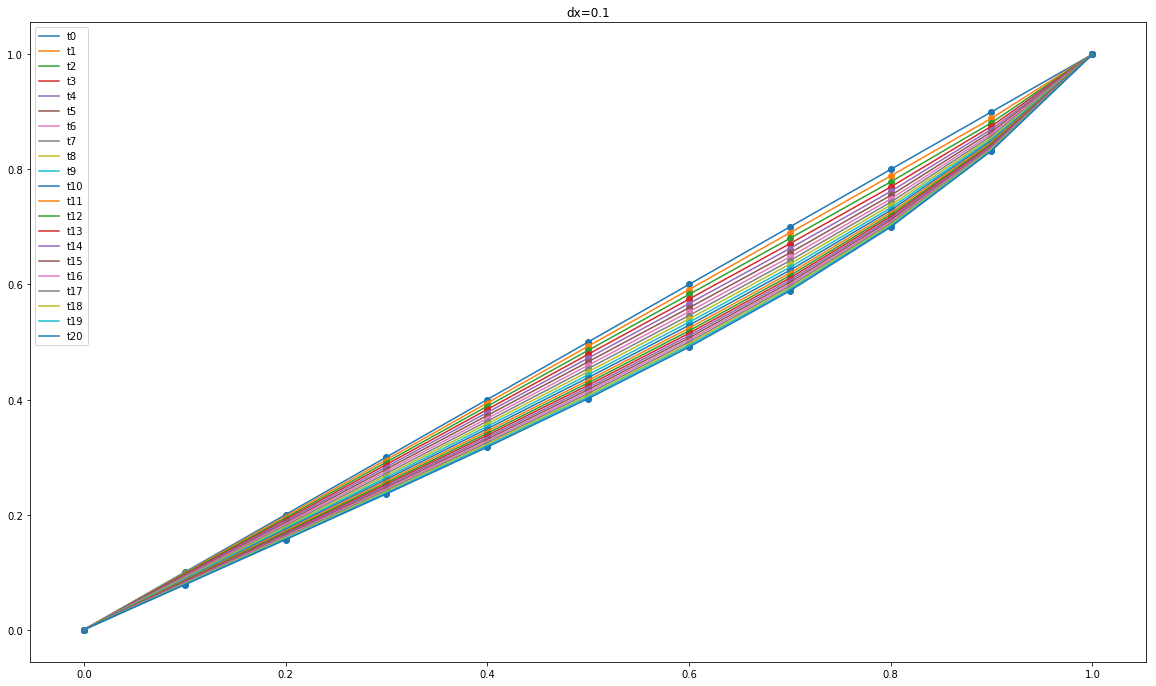

In [142]:
n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
dt = cond.dt
fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(311)
ax.set_title("dx=0.1")
g = []
print(len(y[0]))
for i in range(len(y)):
    x_range = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
    ax.plot(x_range, y[i])
    ax.scatter(x_range, y[i])
    g.append("t"+str(i))
ax.legend(tuple(g))
fig.show()